<a href="https://colab.research.google.com/github/qhung23125005/AIO/blob/main/AIO24/Module3/Projects/SentimentAnalysis/SentimentAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install contractions

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.3/118.3 kB 9.5 MB/s eta 0:00:00


In [10]:
import pandas as pd
import re
import string
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from bs4 import BeautifulSoup
import contractions
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction . text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


#Process data

##Load data

In [27]:
# Load dataset
df = pd.read_csv('./IMDB-Dataset.csv')

print(f'There are {df.shape[0] - df.drop_duplicates().shape[0]} duplicates')
#Remove duplicated rows
df = df.drop_duplicates()

df.head()

There are 418 duplicates


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


##Process data

In [5]:
stop = set(stopwords.words('english'))

In [7]:
def expand_contractions(text):
  return contractions.fix(text)

def preprocess_text(text):
  wl = WordNetLemmatizer()

  soup = BeautifulSoup (text, "html.parser") # Removing html tags

  text = soup.get_text()
  text = expand_contractions ( text ) # Expanding chatwords and contracts clearing contractions
  emoji_clean = re.compile("["
                            u"\U0001F600-\U0001F64F" # emoticons
                            u"\U0001F300-\U0001F5FF" # symbols & pictographs
                            u"\U0001F680-\U0001F6FF" # transport & map symbols
                            u"\U0001F1E0-\U0001F1FF" # flags (iOS)
                            u"\U00002702-\U000027B0"
                            u"\U000024C2-\U0001F251"
                            "]+", flags =re.UNICODE)

  text = emoji_clean.sub(r'', text) # Removing emojis
  text = re.sub(r'\.(?=\S)', '. ',text ) #add space after full stop
  text = re.sub(r'http \S+', '', text ) # remove urls
  text = "".join([
      word.lower() for word in text if word not in string.punctuation
  ])
  text = " ". join ([
    wl. lemmatize ( word ) for word in text . split () if word not in stop and word.isalpha ()
  ]) # lemmatize

  return text

In [8]:
df['review'] = df['review'].apply(preprocess_text)

<ipython-input-7-1843ee097137>:7: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup (text, "html.parser") # Removing html tags


##Visualize data

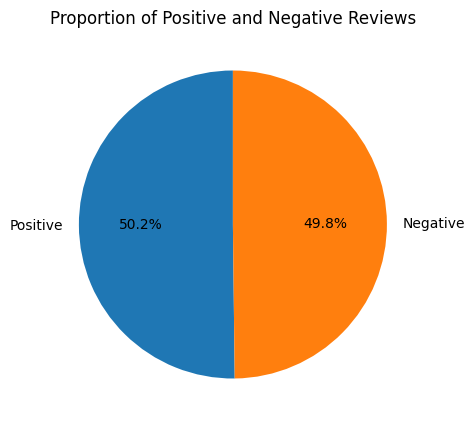

In [12]:
#Using a pie chart to visualize the proportion of neg and pos reviews

freq_pos = df[df['sentiment'] == 'positive'].shape[0]
freq_neg = df[df['sentiment'] == 'negative'].shape[0]

labels = ['Positive', 'Negative']
sizes = [freq_pos, freq_neg]

fig, ax = plt.subplots(figsize=(5, 5))
ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
ax.set_title('Proportion of Positive and Negative Reviews')
plt.show()

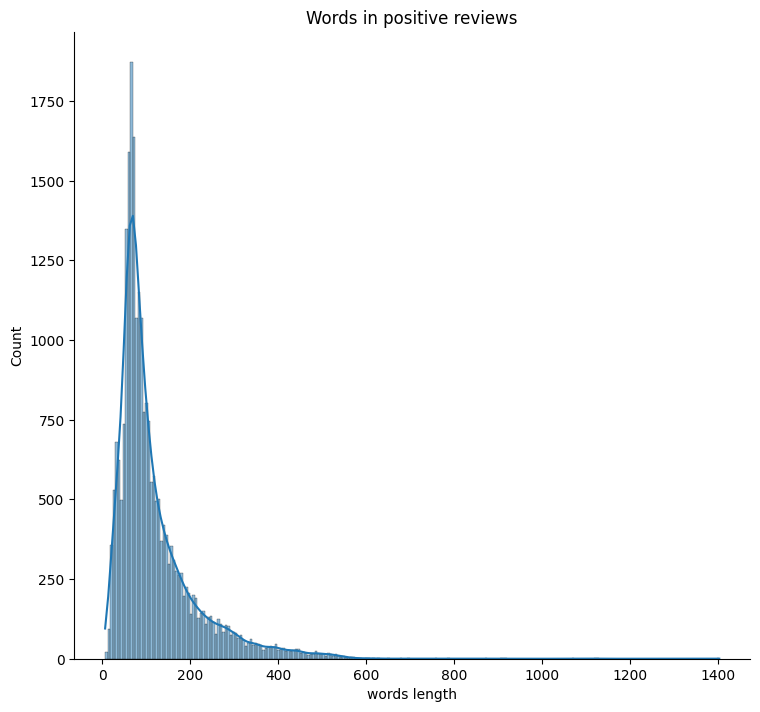

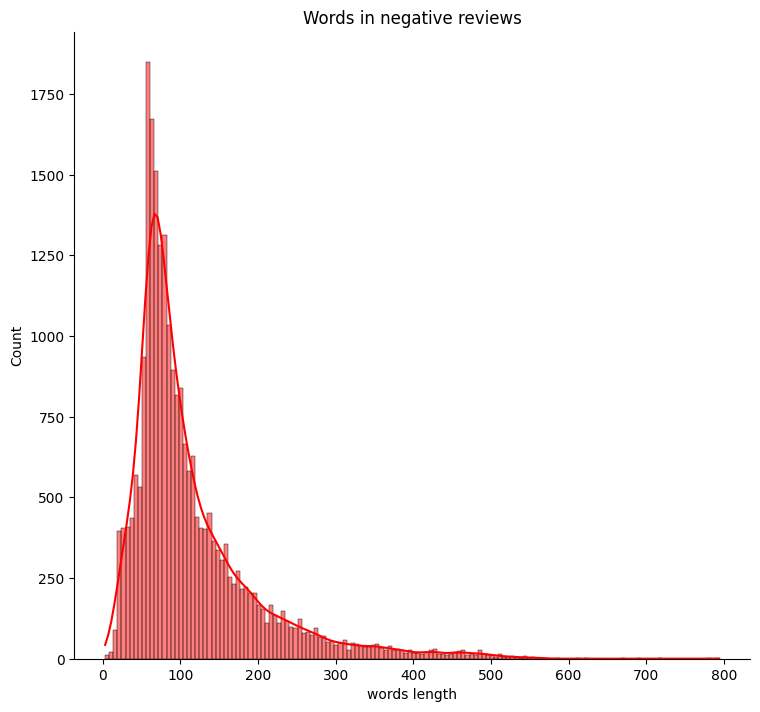

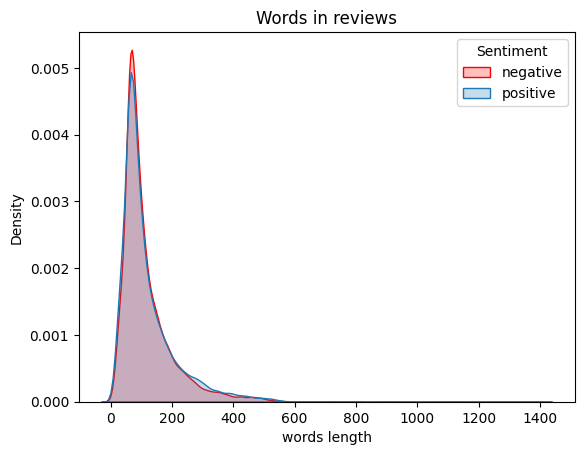

In [16]:
#Visualize the lengths of the samples according to the review
words_len = df['review'].str.split().map(lambda x: len(x))

df_temp = df. copy ()
df_temp['words length'] = words_len

hist_positive = sns. displot (
    data = df_temp[df_temp['sentiment'] == 'positive'],
    x="words length", hue="sentiment", kde=True,
    height = 7, aspect = 1.1 , legend =False
).set(title = 'Words in positive reviews')
plt.show ( hist_positive )

hist_negative = sns. displot (
    data = df_temp[df_temp['sentiment'] == 'negative'],
    x="words length", hue="sentiment", kde=True,
    height = 7, aspect = 1.1 , legend =False, palette = ['red']
).set(title = 'Words in negative reviews')
plt.show ( hist_negative )

kernel_distibution_number_words_plot = sns.kdeplot(
    data = df_temp, x = "words length", hue= "sentiment", fill =True,
    palette =[sns.color_palette()[0] , 'red']
).set (title = 'Words in reviews')

plt.legend ( title ='Sentiment', labels =['negative', 'positive'])
plt.show(kernel_distibution_number_words_plot)

##Create the train and test data

In [17]:
x_data = df['review']
y_data = df['sentiment']

In [18]:
label_encoder = LabelEncoder()
df['sentiment'] = label_encoder.fit_transform(df['sentiment'])

x_train , x_test , y_train , y_test = train_test_split (
  x_data , y_data , test_size =0.2 , random_state =42
)

In [21]:
tfidf_vectorizer = TfidfVectorizer ( max_features =10000)
x_train_encoded = tfidf_vectorizer.fit_transform(x_train)
x_test_encoded = tfidf_vectorizer.transform(x_test)

#Train the model

##Decision Tree

In [22]:
dt_classifier = DecisionTreeClassifier(
    criterion='entropy',
    random_state=42
)
dt_classifier.fit(x_train_encoded, y_train)


DecisionTreeClassifier(criterion='entropy', random_state=42)

In [23]:
y_pred = dt_classifier . predict ( x_test_encoded )
accuracy = accuracy_score ( y_test , y_pred )
print("Accuracy:", accuracy)

Accuracy: 0.7129172128667944


##Random Forest

In [24]:
rf_classifier = RandomForestClassifier(
    random_state=42
)
rf_classifier.fit(x_train_encoded, y_train)

RandomForestClassifier(random_state=42)

In [25]:
y_pred = rf_classifier . predict ( x_test_encoded )
accuracy = accuracy_score ( y_test , y_pred )
print("Accuracy:", accuracy)

Accuracy: 0.8437027326812544
